# Exploratory Data Analysis of processed data
The goal of this notebook is to analyze what's inside two files created under `data/processed` directory after running `process_raw_data.py`.

## Setup

In [2]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sys, os
utils_dir = os.path.abspath('.') + '/shared_scripts'
sys.path.append(utils_dir)
import utils

## What's inside processed data directory?

In [2]:
with open("data/processed/Mouse28-140313_processed.pkl", "rb") as f:
    data = pkl.load(f)
    print(data.keys())

dict_keys(['session', 'state_times', 'angle_list', 'pos_sampling_rate', 'angle_times', 'nShanks', 'nCells', 'spike_times', 'cells_with_weird_clustering'])


### 0. Keys with single values (not arrays etc.)

In [3]:
arraylike = []
print(f"Keys with single values:")
for k,v in data.items():
    if type(v) not in [list, dict, np.ndarray]:
        print(f"{k}: {v}")
    else:
        arraylike.append(k)
print(f"\nKeys that need examination are: {arraylike}")

Keys with single values:
session: Mouse28-140313
pos_sampling_rate: 39.0625
nShanks: 11
cells_with_weird_clustering: 0

Keys that need examination are: ['state_times', 'angle_list', 'angle_times', 'nCells', 'spike_times']


### 1. state_times
**Summary**:
- `state_times` dict has three keys corresponding to different sleep cycle phases (Wake, REM or SWS which is Slow Wave Sleep)
- each of keys holds a 2-dimensional numpy array of respectively: 1, 23 and 45 datapoints
- X and Y coordinates in each group are strongly linearly correlated

In [4]:
data['state_times'].keys()

dict_keys(['Wake', 'REM', 'SWS'])

In [5]:
state_times = data["state_times"]

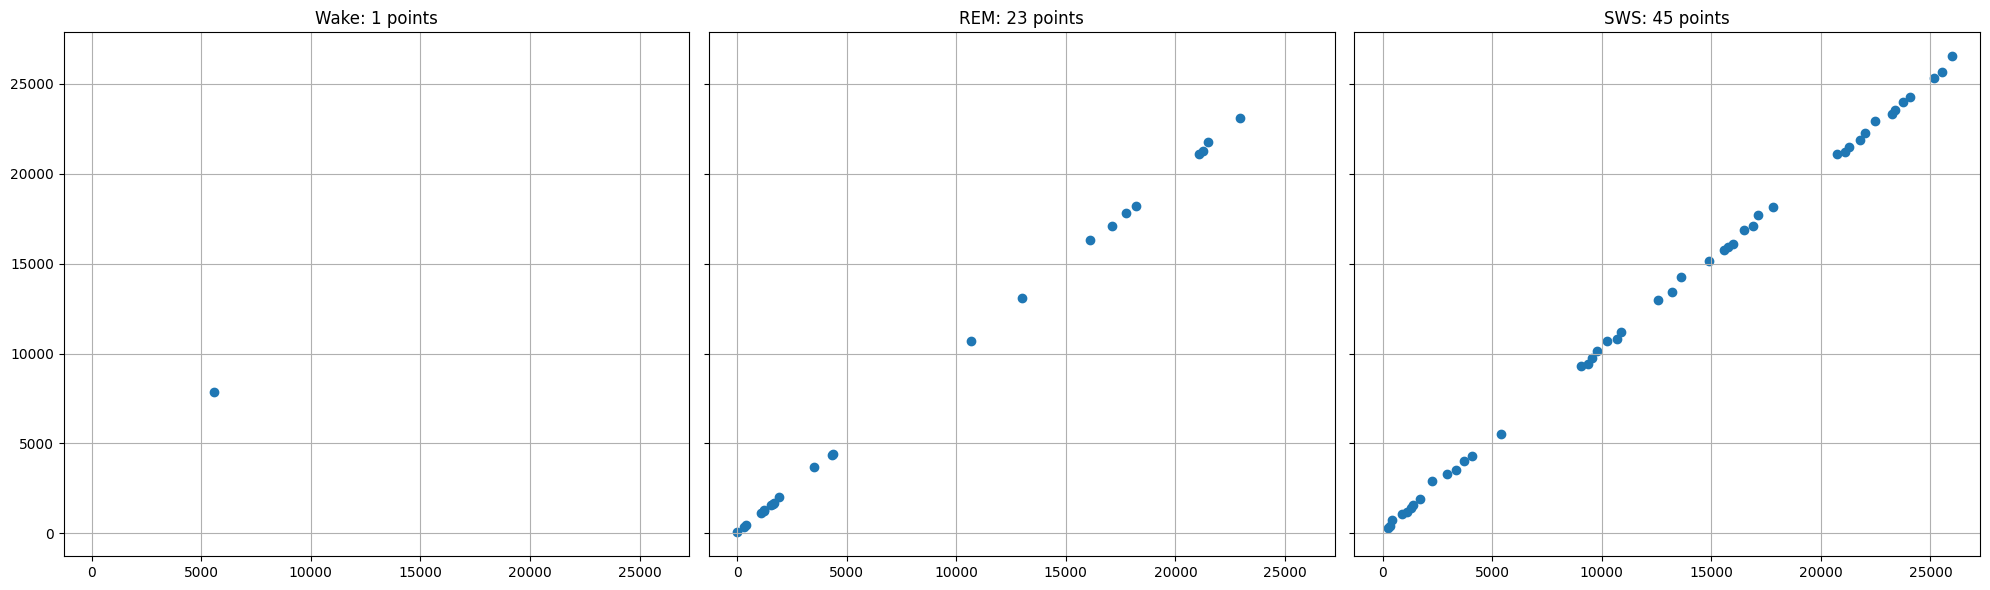

In [6]:
fig, axes = plt.subplots(1,3, figsize = (20,6), sharex = True, sharey= True)
for ax, key in zip(axes.flatten(), state_times):    
    arr = np.array(state_times[key]).transpose()
    ax.scatter(arr[0], arr[1])
    ax.set_title(f"{key}: {arr.shape[1]} points")
    ax.grid()
plt.tight_layout()

### 2. angle_list
**Summary:** 
- this is a list containing 1104518 observations of measured angle between 0 and 360 radians.
- it seems that there are numerous sharp changes in head rotation

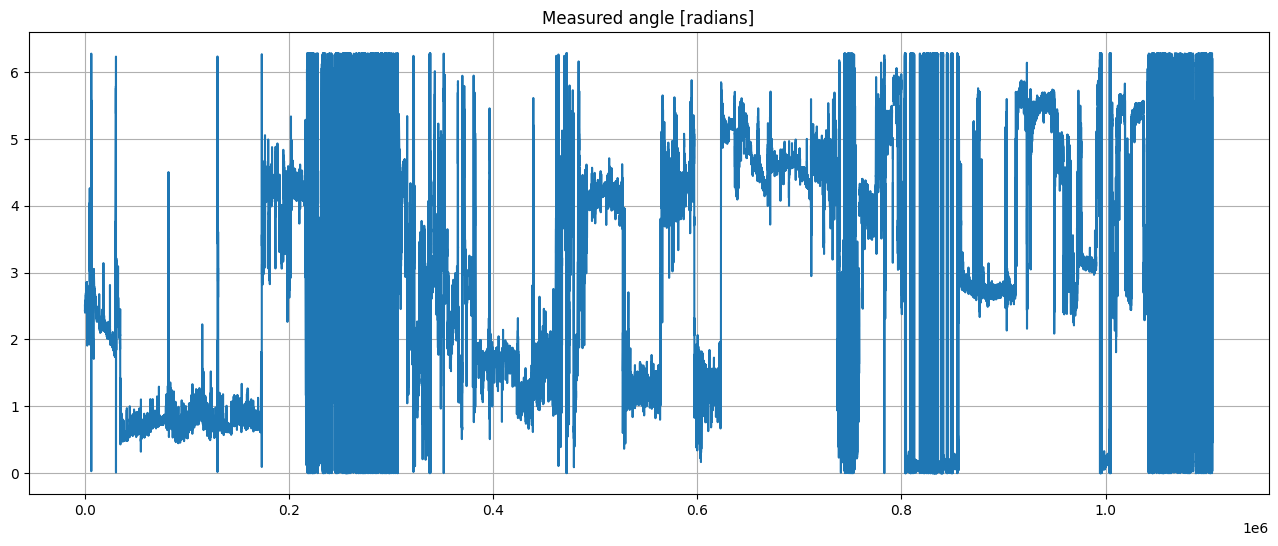

In [7]:
angles = pd.Series(data["angle_list"])
fig, ax = plt.subplots(1,1,figsize = (16,6))
ax.plot(angles)
ax.grid()
ax.set_title("Measured angle [radians]")
plt.show()

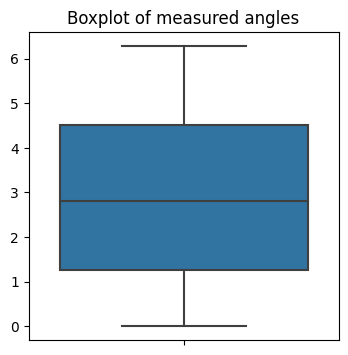

In [8]:
fig, ax = plt.subplots(1,1,figsize = (4,4))
sns.boxplot(y =angles)
plt.title('Boxplot of measured angles')
plt.show()

In [9]:
2*np.math.pi - angles.max()

8.530717958610268e-05

In [10]:
len(angles)

1104518

### 3. angle_times
**Summary:**
- `angle_times` is a 1-dimensional array containing 1104518 values (the same number as in `angle_list`)
- difference between time of consecutive measurements of angle is 0.026 with 4th decimal number precision

In [11]:
angle_times = data["angle_times"]
angle_times.shape

(1104518,)

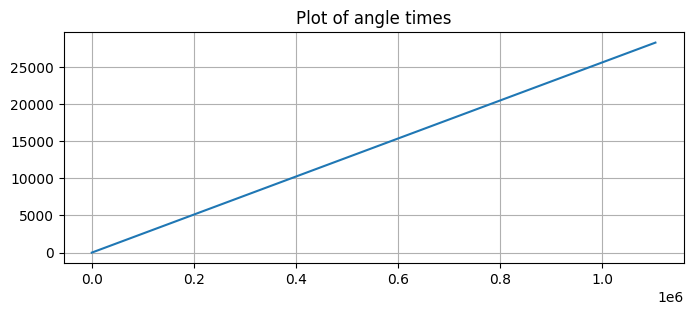

In [12]:
angle_times = pd.Series(angle_times)
fig, ax = plt.subplots(1,1,figsize = (8,3))
ax.plot(angle_times)
ax.grid()
ax.set_title("Plot of angle times")
plt.show()

In [13]:
angle_times.head()

0    0.0000
1    0.0256
2    0.0512
3    0.0768
4    0.1024
dtype: float64

In [14]:
(angle_times.to_numpy()[1:] - angle_times.to_numpy()[:-1]).max()

0.025600000000849832

In [15]:
(angle_times.to_numpy()[1:] - angle_times.to_numpy()[:-1]).min()

0.025599999997211853

### 4. nCells
**Summary:**
- number of datapoints corresponds to number of shanks in dataset, so we assume that each correspond to different shank of electrode
- total number of cells is 62

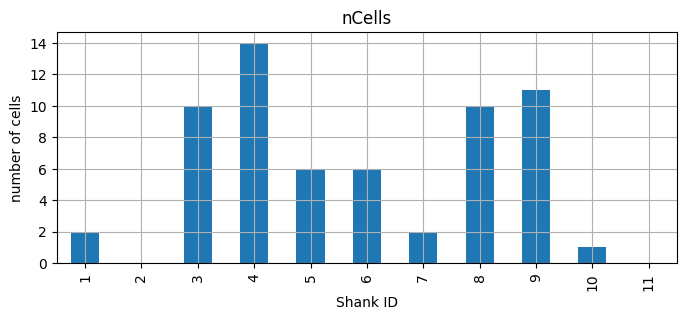

In [16]:
ncells = pd.Series(data["nCells"], index = pd.Series(range(1,12)))
fig, ax = plt.subplots(1,1,figsize = (8,3))
ncells.plot.bar(ax = ax, xlabel = "Shank ID", ylabel = "number of cells")
ax.grid()
ax.set_title("nCells")
plt.show()

In [17]:
ncells.sum()

62.0

### 5. spike_times
**Summary:**
- there are 62 keys in `spike_times` dict - this is the same number as total number of cells in `nCells`, so I assume that keys correspond to coordinates of particular cells as if they were on 2d grid
- minimal number of spike times for a cell is 3695 and maximal is 1179601
- all spike time arrays have values range between 0 and something around 28275 with subtle differences 

In [18]:
data["spike_times"].keys()

dict_keys([(0, 0), (0, 1), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 0), (6, 1), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (9, 0)])

In [19]:
data["spike_times"].keys().__len__()

62

In [20]:
spike_times_lengths = {k: len(data["spike_times"][k]) for k in data["spike_times"]}
spike_times_df = pd.DataFrame.from_dict(spike_times_lengths, orient = "index").reset_index().rename({0: "num_of_spike_times", "index": "grid_id"}, axis = 1)
spike_times_df.sort_values(by = "num_of_spike_times").head()

,grid_id,num_of_spike_times
11,"(2, 9)",3695
5,"(2, 3)",8056
17,"(3, 5)",8980
27,"(4, 1)",9393
52,"(8, 2)",11178


In [21]:
spike_times_df.sort_values(by = "num_of_spike_times").tail()

,grid_id,num_of_spike_times
29,"(4, 3)",773907
25,"(3, 13)",853000
22,"(3, 10)",888530
38,"(6, 0)",913742
31,"(4, 5)",1179601


In [22]:
data["spike_times"][(0,0)].shape

(175738,)

#### Spike times of different cells

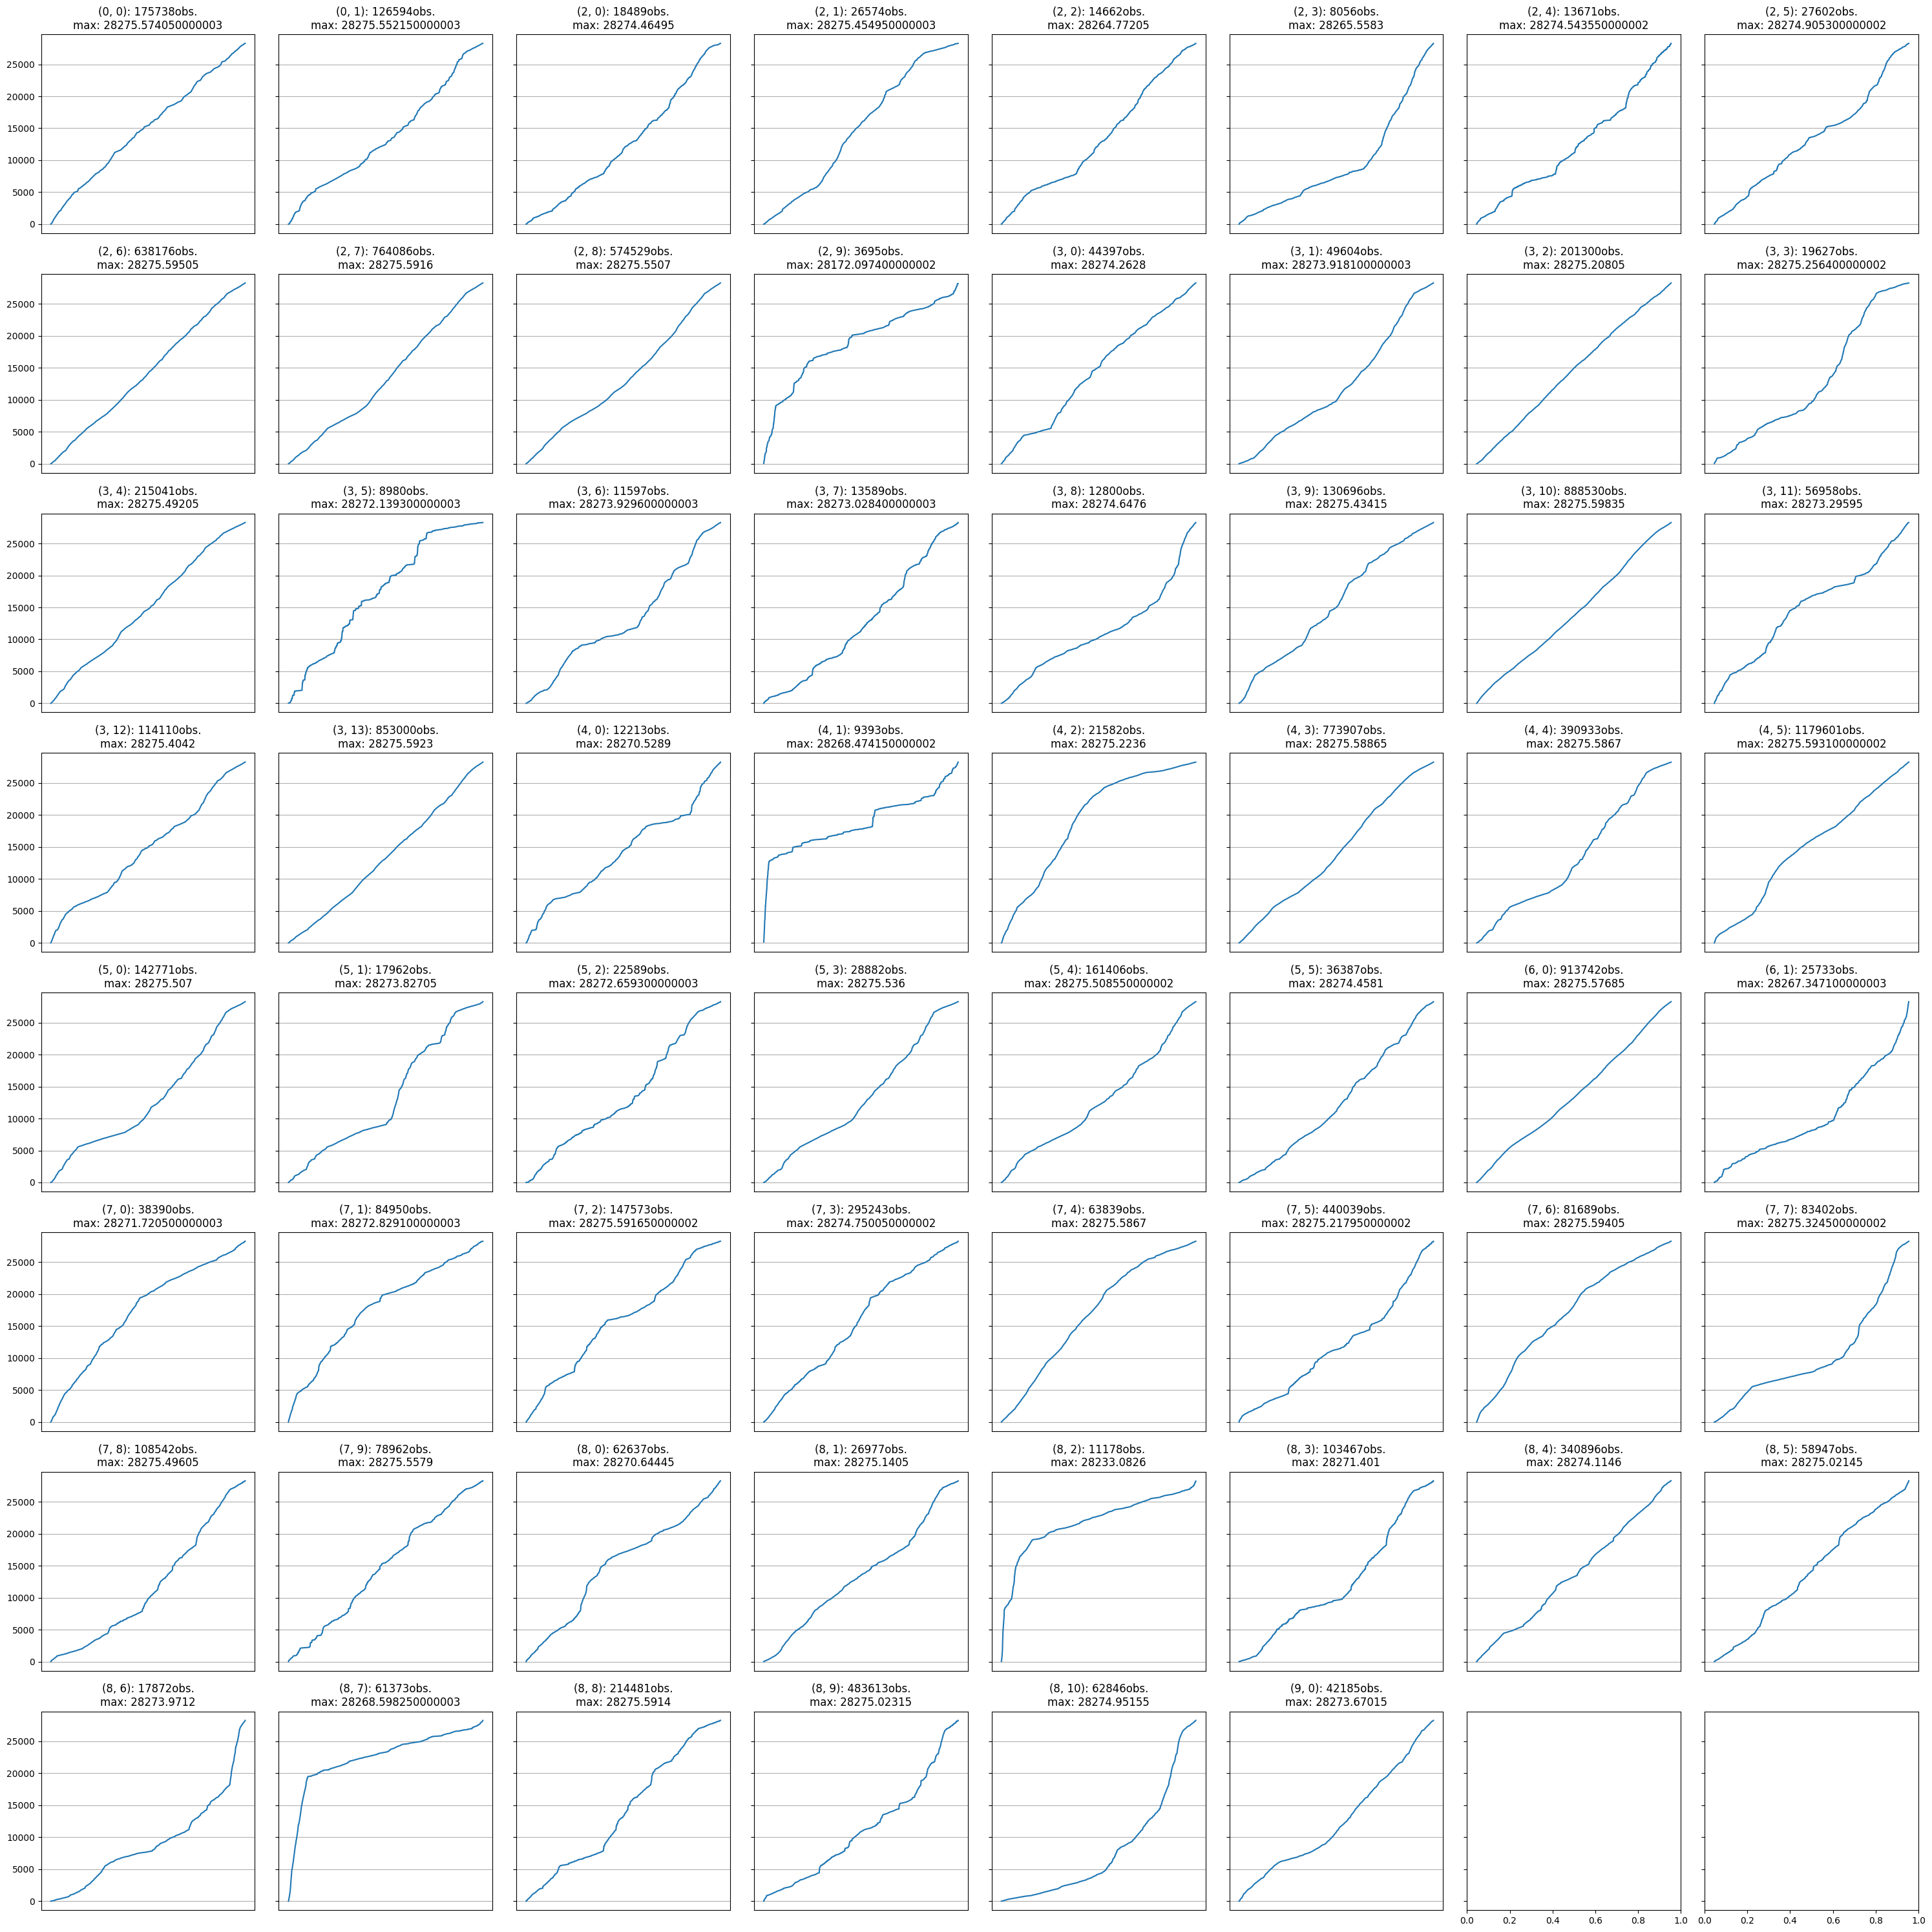

In [45]:
fig, axes = plt.subplots(8,8,figsize = (30,30), sharey = True)
for ax, key in zip(axes.flatten(), data["spike_times"].keys()):
    try:
        spikes = pd.Series(data["spike_times"][key])
        ax.plot(spikes)
        ax.get_xaxis().set_visible(False)
        ax.grid()
        ax.set_title(f"{key}: {len(spikes)}obs.\nmax: {spikes.max()}")
    except Exception as e:
        print(f"Error with key {key} or ax {ax}: {e}")
        ax.set_visible(False)

plt.tight_layout()

#### Number of spikes for each cell

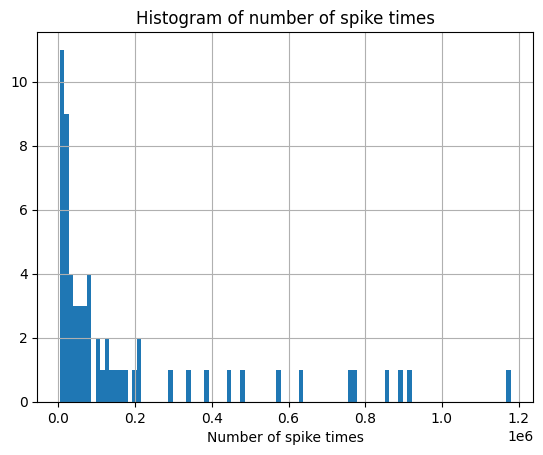

In [43]:
spike_times_df["num_of_spike_times"].hist(bins = 100)
plt.xlabel("Number of spike times")
plt.title("Histogram of number of spike times")
plt.show()

## What's inside kernel_rates file?
**Summary**:
- `kernel_rates` contains nested dictionary with 4 levels.
- `cells`, `params` and `session` keys at level 0 contain information about used parameters and session
- `Wake` key has one sub-key which is `((5565.0, 7851.4))` and probably represents start and end times of wake phase. It has 3 arrays and one dict inside. 
- these arrays are `angle_times`, `angles` and `rate_times` and each has shape (45727,).
- `rates` key at level 2 contains 62 items indexed by grid coordinates of cells(?) and values are arrays of the same shape as above

In [3]:
with open("data/analyses/kernel_rates/100ms_sigma/Mouse28-140313_kernel_rates.pkl", "rb") as f:
    rates = pkl.load(f)

Rates file is a big nested dictionary so we use utils function to visualize its structure.

In [37]:
utils.visualise_dict(rates)

KEY                       LEVEL           TYPE      
-------------------------------------------------------------------------------
Wake                      0               <class 'dict'>
  (5565.0, 7851.4)        1               <class 'dict'>
    angle_times           2               <class 'numpy.ndarray'>
    angles                2               <class 'numpy.ndarray'>
    rate_times            2               <class 'numpy.ndarray'>
    rates                 2               <class 'dict'>
      (0, 0)              3               <class 'numpy.ndarray'>
      (0, 1)              3               <class 'numpy.ndarray'>
      (2, 0)              3               <class 'numpy.ndarray'>
      (2, 1)              3               <class 'numpy.ndarray'>
      (2, 2)              3               <class 'numpy.ndarray'>
      (2, 3)              3               <class 'numpy.ndarray'>
      (2, 4)              3               <class 'numpy.ndarray'>
      (2, 5)              3         

In [6]:
for k,v in rates["Wake"][(5565.0, 7851.4)].items():
    try: 
        print(f"{k}: {v.shape} array")
    except:
        print(f"{k}: not array")

rates: not array
rate_times: (45727,) array
angles: (45727,) array
angle_times: (45727,) array


In [7]:
for k,v in rates["Wake"][(5565.0, 7851.4)]["rates"].items():
    print(f"{k}: {v.shape} array")

(0, 0): (45727,) array
(0, 1): (45727,) array
(2, 0): (45727,) array
(2, 1): (45727,) array
(2, 2): (45727,) array
(2, 3): (45727,) array
(2, 4): (45727,) array
(2, 5): (45727,) array
(2, 6): (45727,) array
(2, 7): (45727,) array
(2, 8): (45727,) array
(2, 9): (45727,) array
(3, 0): (45727,) array
(3, 1): (45727,) array
(3, 2): (45727,) array
(3, 3): (45727,) array
(3, 4): (45727,) array
(3, 5): (45727,) array
(3, 6): (45727,) array
(3, 7): (45727,) array
(3, 8): (45727,) array
(3, 9): (45727,) array
(3, 10): (45727,) array
(3, 11): (45727,) array
(3, 12): (45727,) array
(3, 13): (45727,) array
(4, 0): (45727,) array
(4, 1): (45727,) array
(4, 2): (45727,) array
(4, 3): (45727,) array
(4, 4): (45727,) array
(4, 5): (45727,) array
(5, 0): (45727,) array
(5, 1): (45727,) array
(5, 2): (45727,) array
(5, 3): (45727,) array
(5, 4): (45727,) array
(5, 5): (45727,) array
(6, 0): (45727,) array
(6, 1): (45727,) array
(7, 0): (45727,) array
(7, 1): (45727,) array
(7, 2): (45727,) array
(7, 3):

### Plots of firing rates in Wake phase

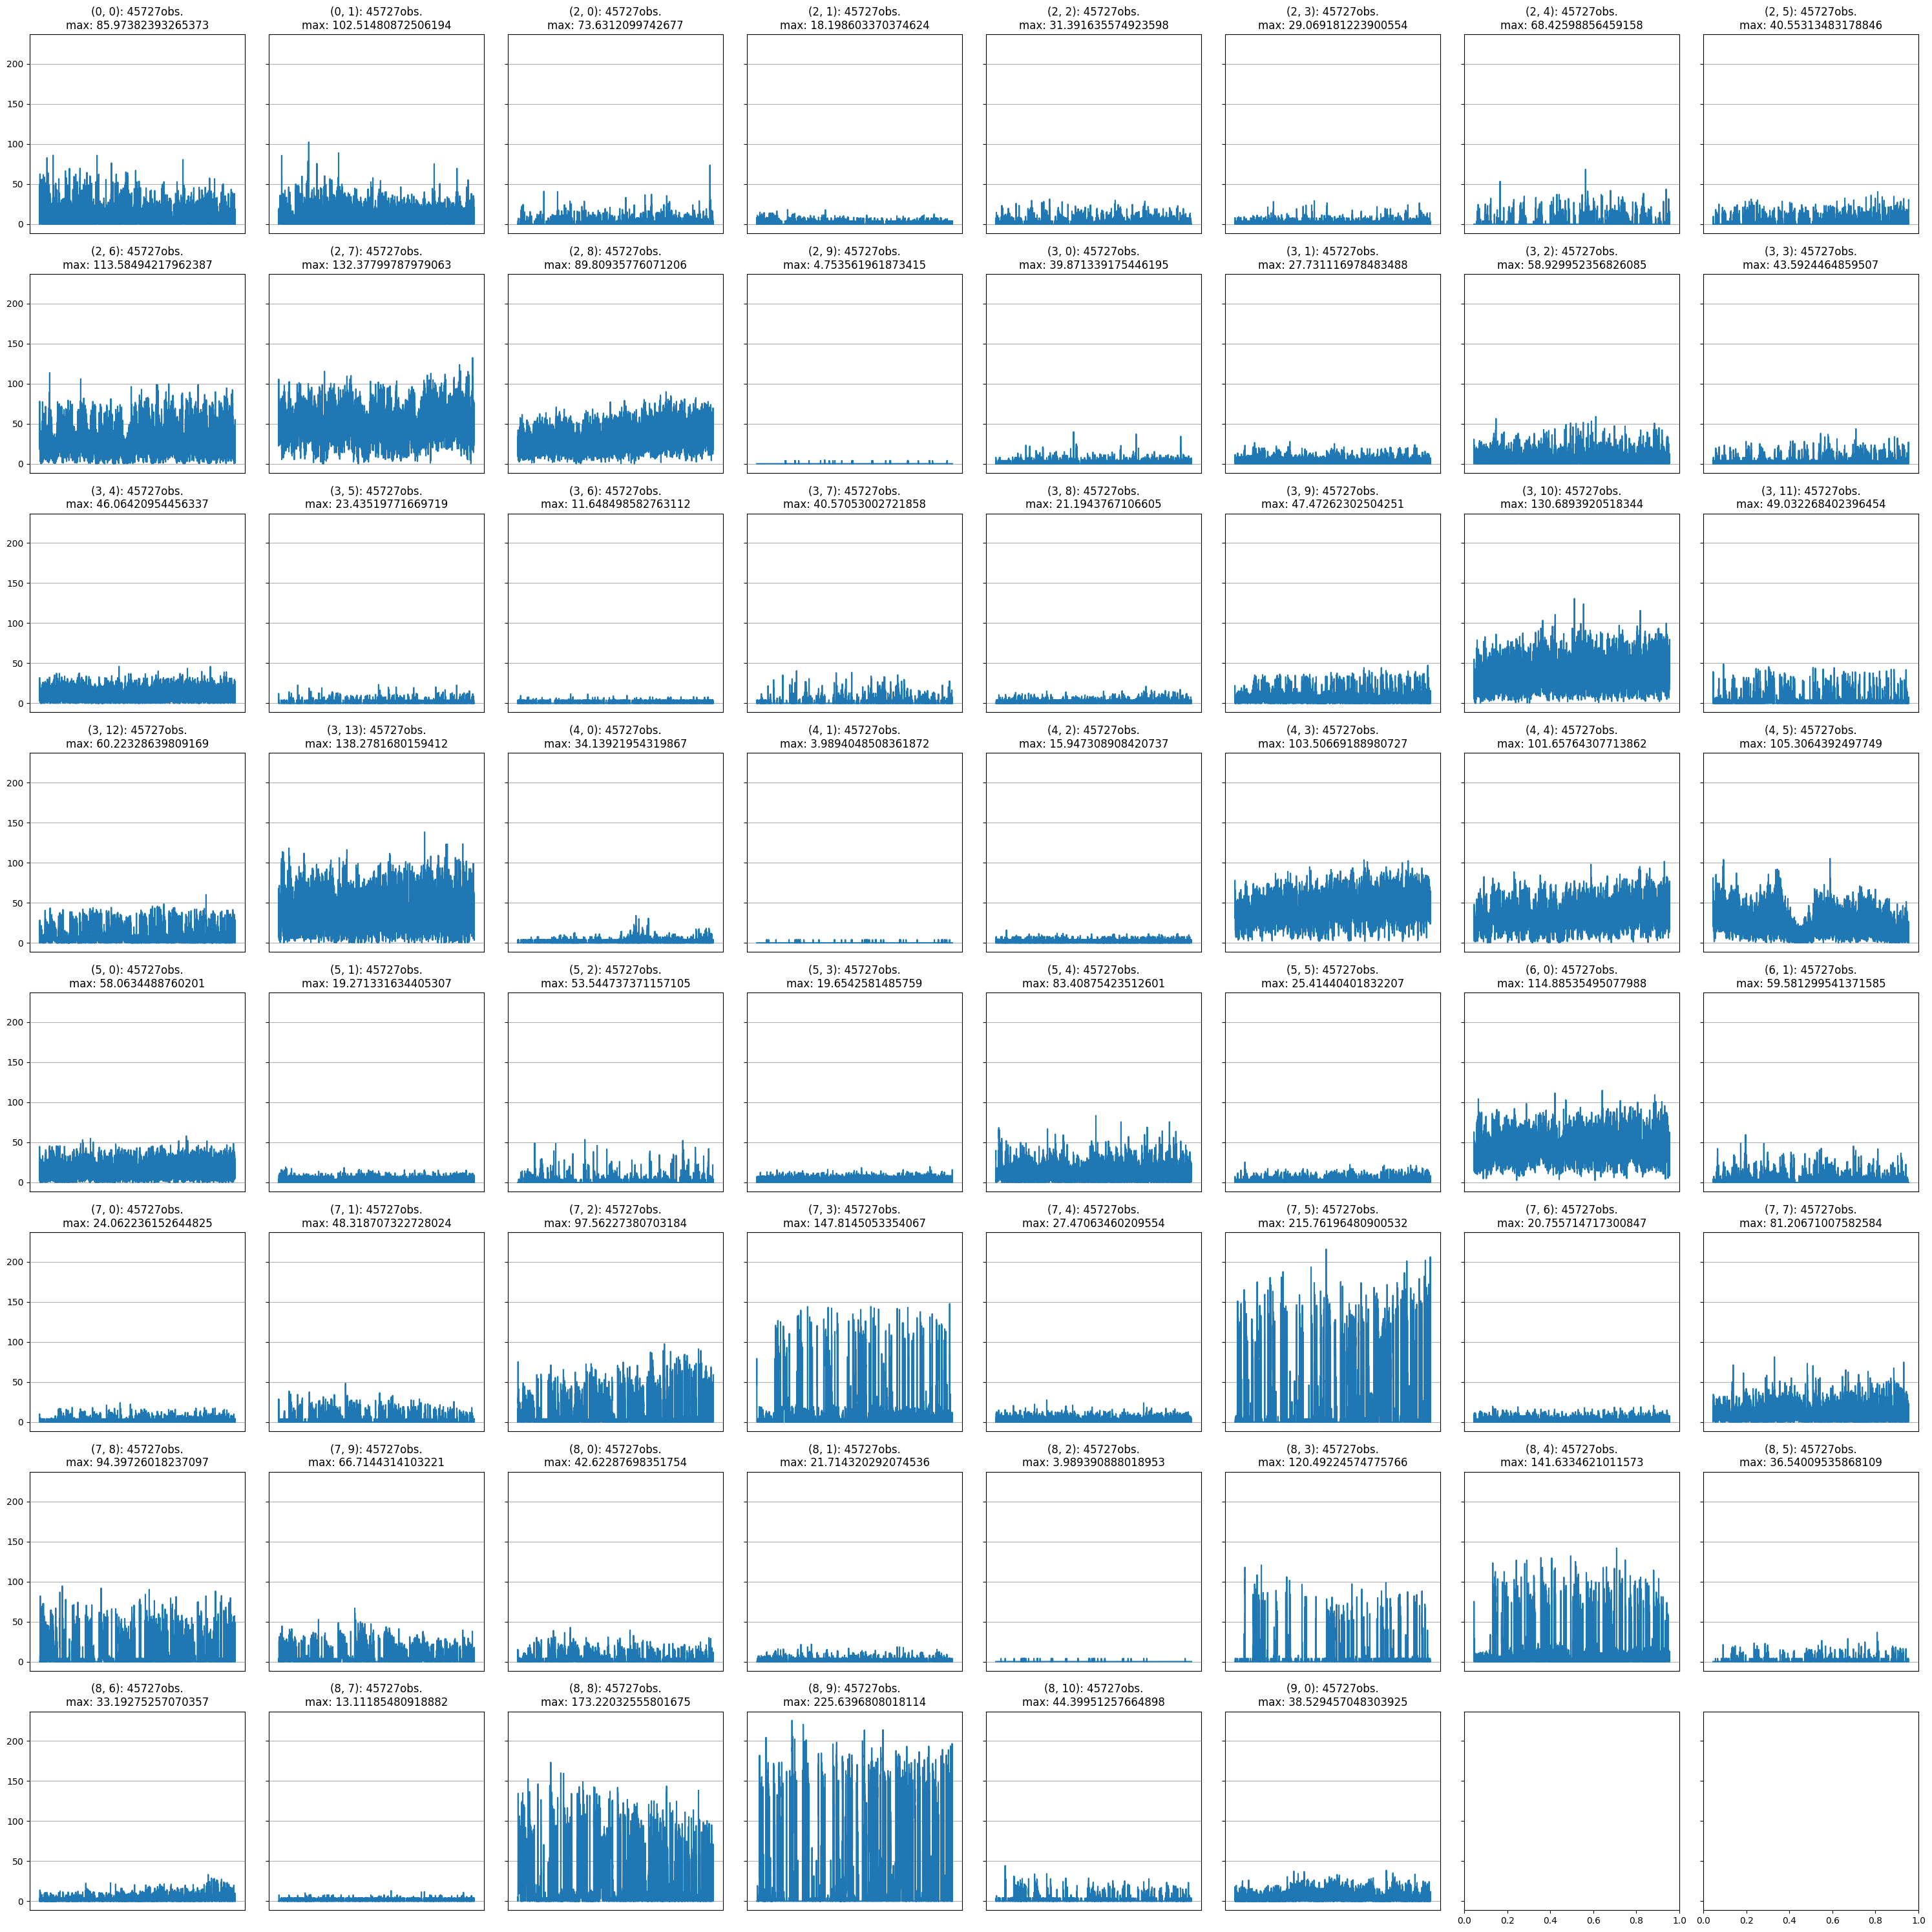

In [9]:
fig, axes = plt.subplots(8,8,figsize = (30,30), sharey = True)
for ax, (key,array) in zip(axes.flatten(), rates["Wake"][(5565.0, 7851.4)]["rates"].items()):
    try:
        ax.plot(array)
        ax.get_xaxis().set_visible(False)
        ax.grid()
        ax.set_title(f"{key}: {len(array)}obs.\nmax: {array.max()}")
    except Exception as e:
        print(f"Error with key {key} or ax {ax}: {e}")
        ax.set_visible(False)

plt.tight_layout()